Installing prophet package (this may take a minute)...



Processing NIFTY 50_cleaned.csv ...


09:41:41 - cmdstanpy - INFO - Chain [1] start processing
09:41:45 - cmdstanpy - INFO - Chain [1] done processing
Exception ignored in: <function tqdm.__del__ at 0x00000226A3611090>
Traceback (most recent call last):
  File "C:\Users\sohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\sohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


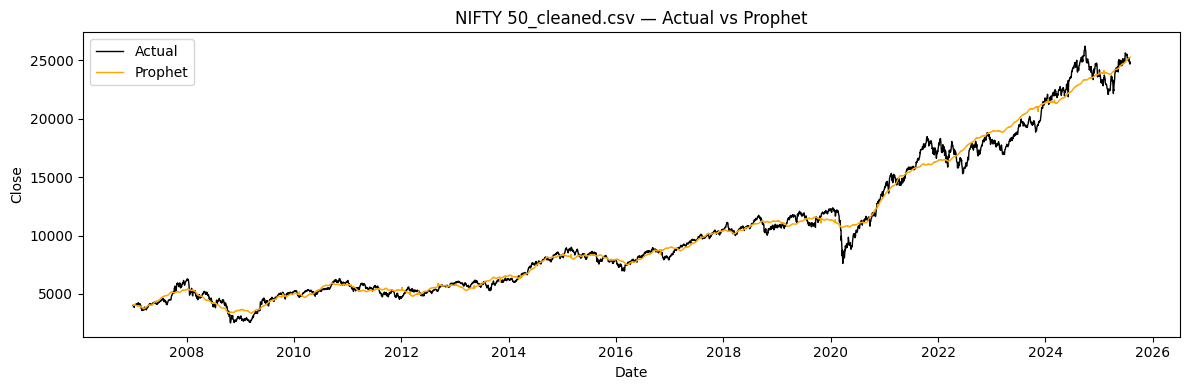

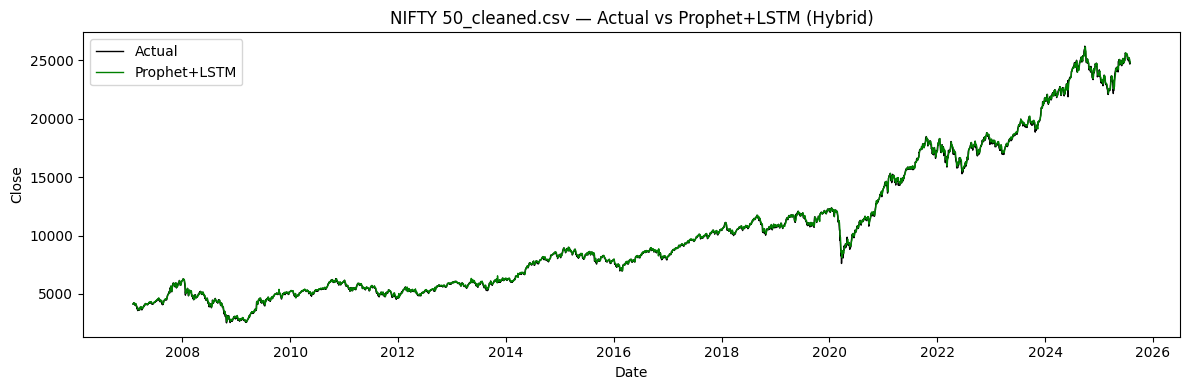


Processing NIFTY AUTO_cleaned.csv ...


09:47:46 - cmdstanpy - INFO - Chain [1] start processing
09:47:48 - cmdstanpy - INFO - Chain [1] done processing


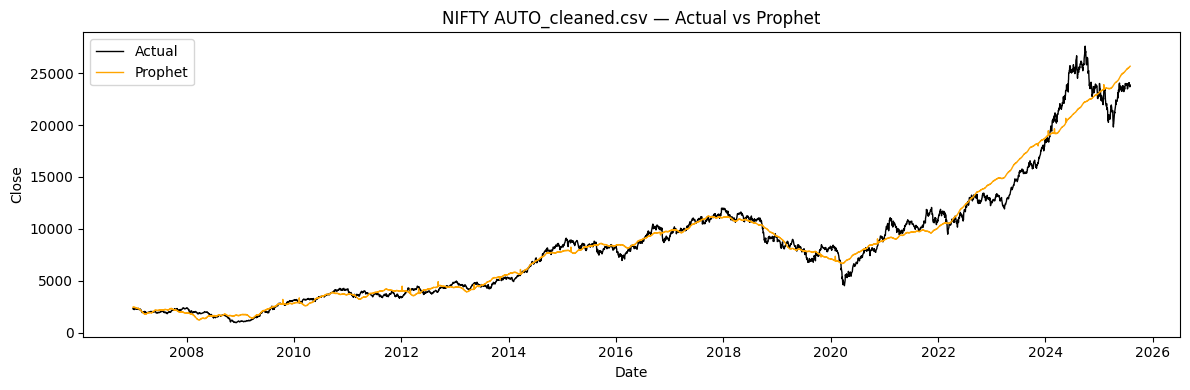

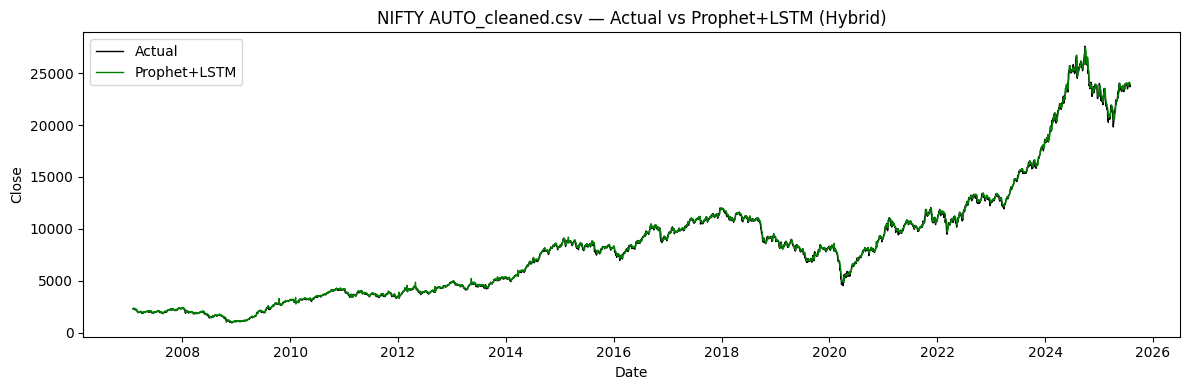


Processing NIFTY BANK_cleaned.csv ...


09:53:29 - cmdstanpy - INFO - Chain [1] start processing
09:53:32 - cmdstanpy - INFO - Chain [1] done processing


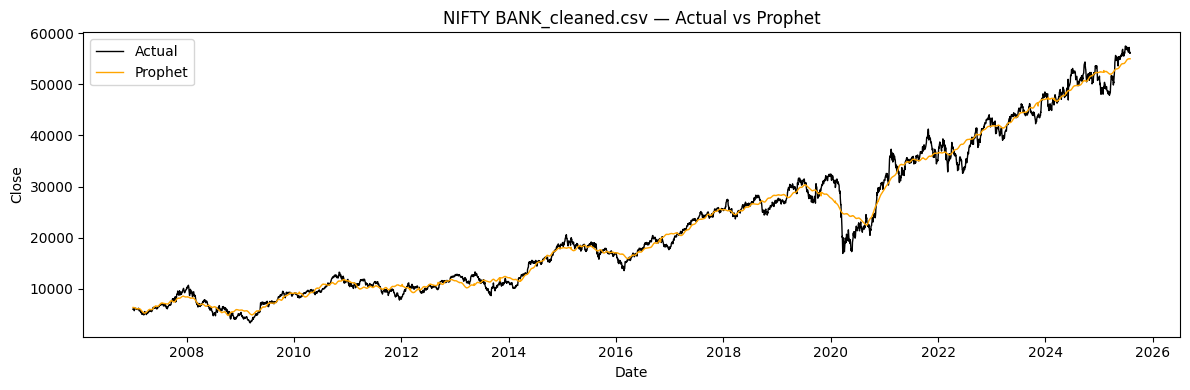

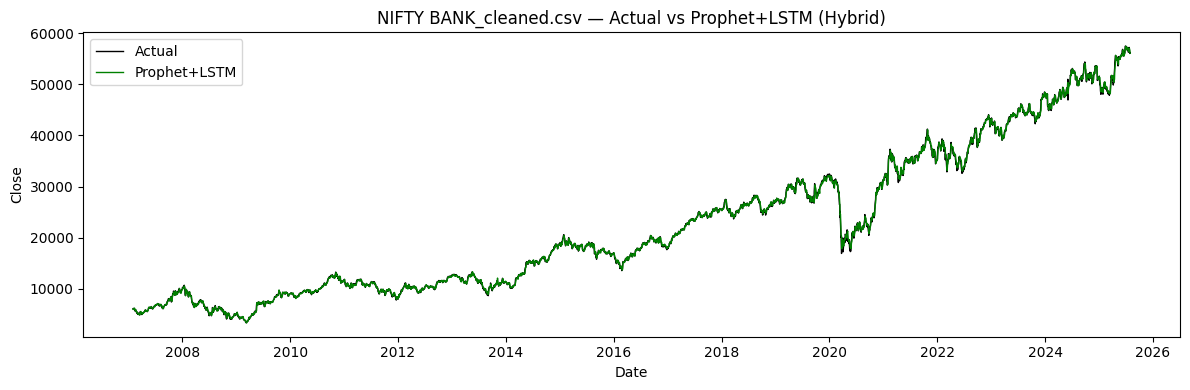


Processing NIFTY CHEMICALS_cleaned.csv ...


09:58:40 - cmdstanpy - INFO - Chain [1] start processing
09:58:42 - cmdstanpy - INFO - Chain [1] done processing


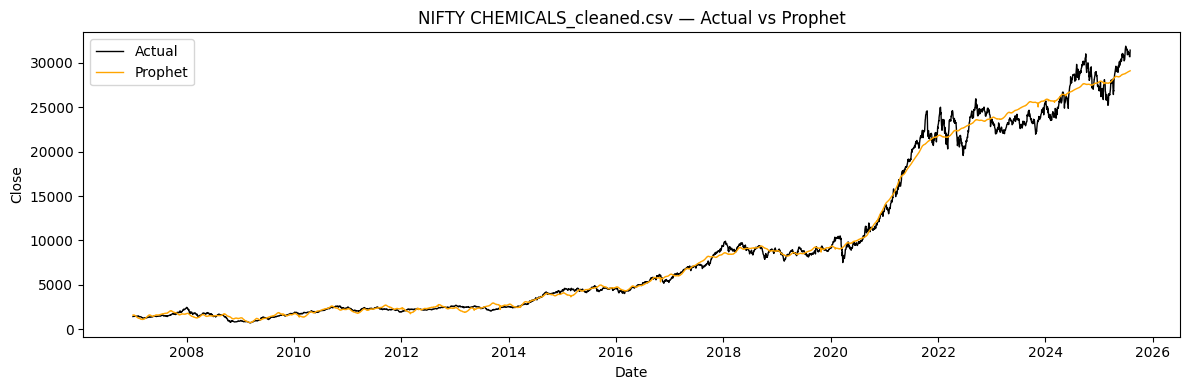

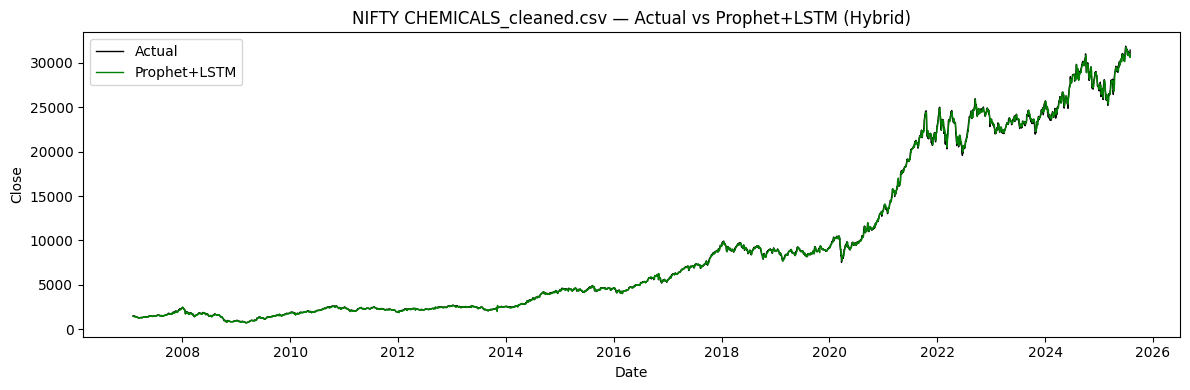


Processing NIFTY CONSUMER DURABLES_cleaned.csv ...


10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing


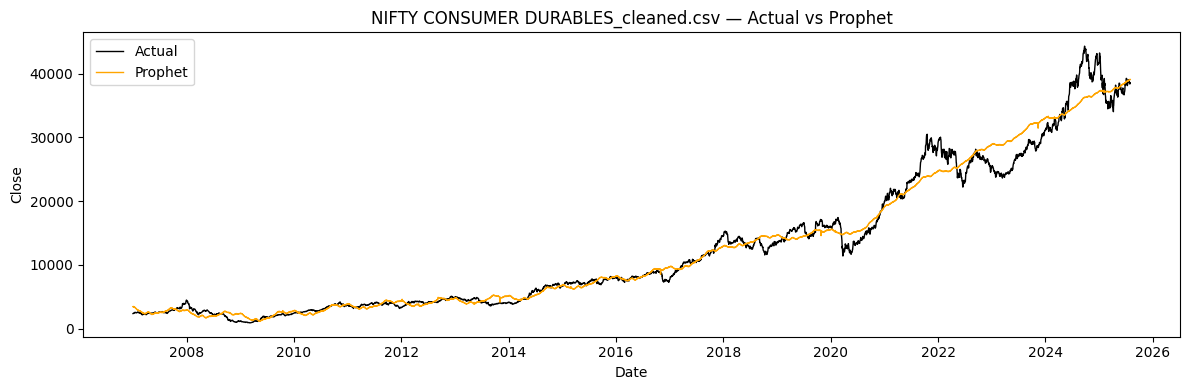

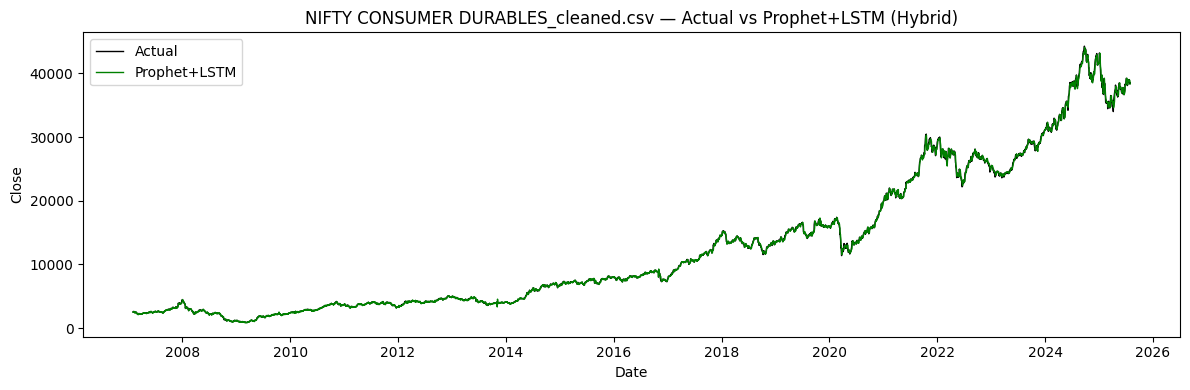


Processing NIFTY FINANCIAL SERVICES_cleaned.csv ...


10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:08:48 - cmdstanpy - INFO - Chain [1] done processing


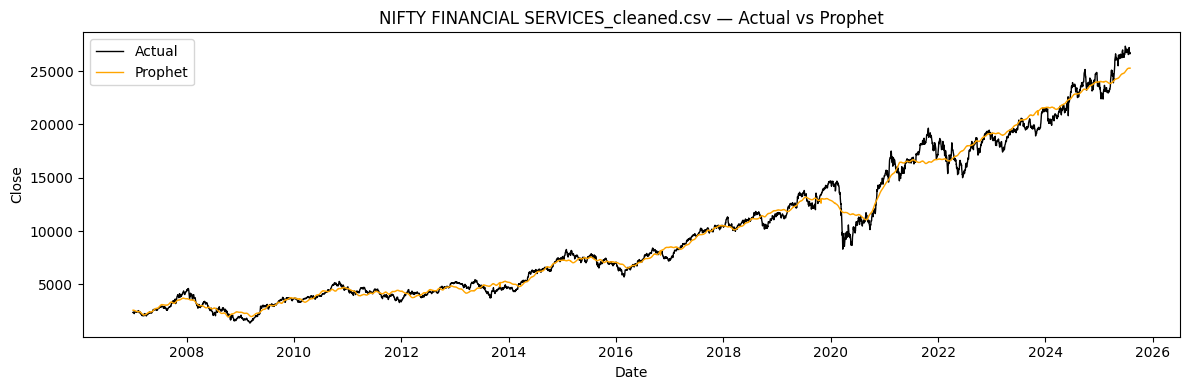

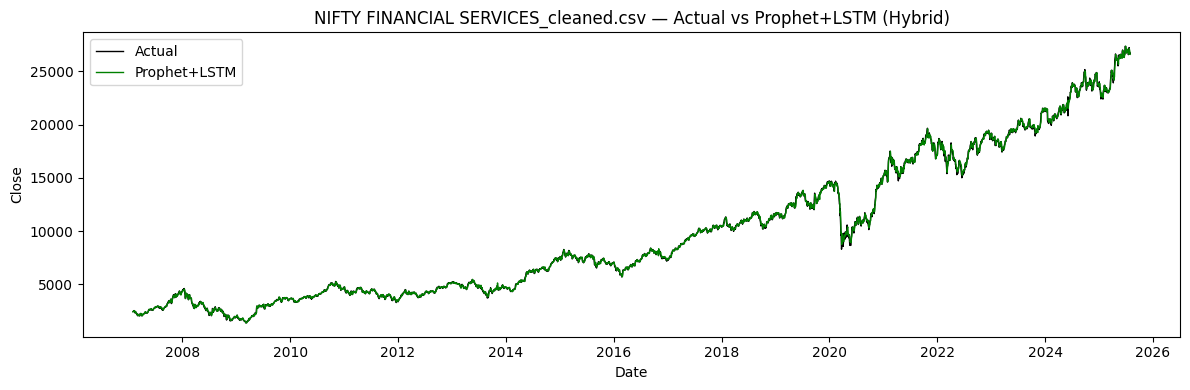


Processing NIFTY FMCG_cleaned.csv ...


10:13:46 - cmdstanpy - INFO - Chain [1] start processing
10:13:47 - cmdstanpy - INFO - Chain [1] done processing


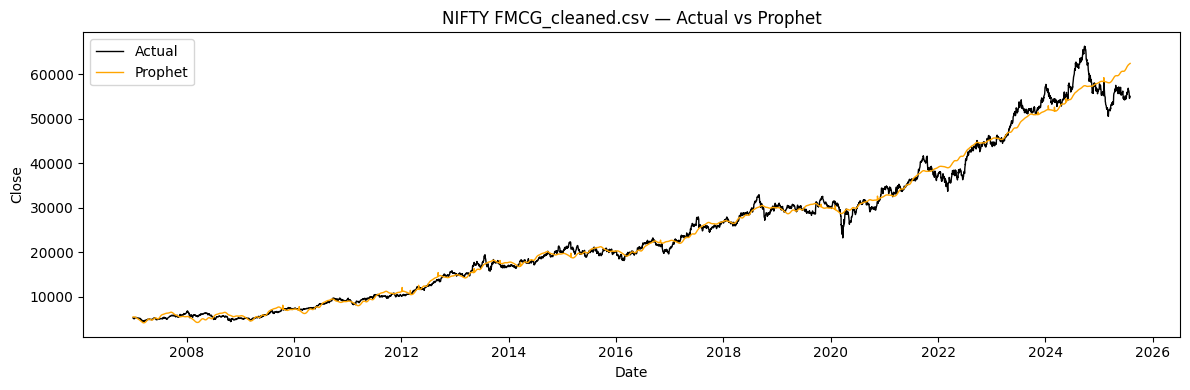

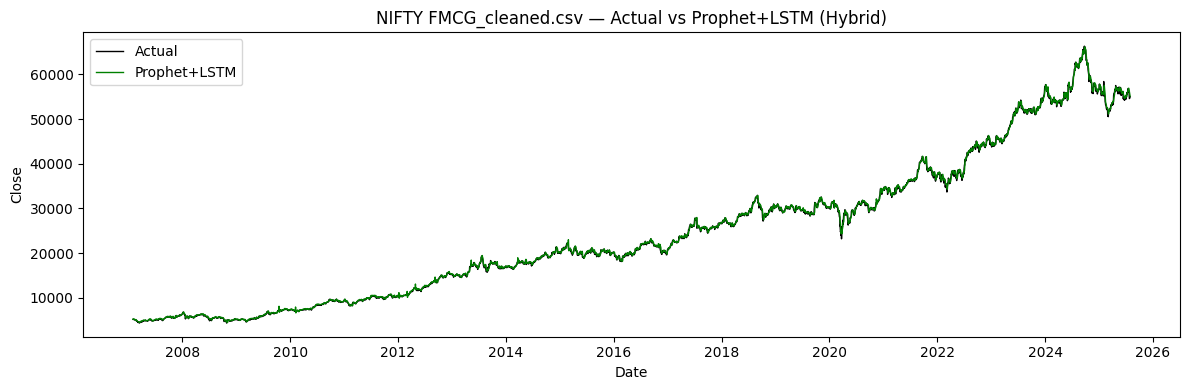


Processing NIFTY IT_cleaned.csv ...


10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing


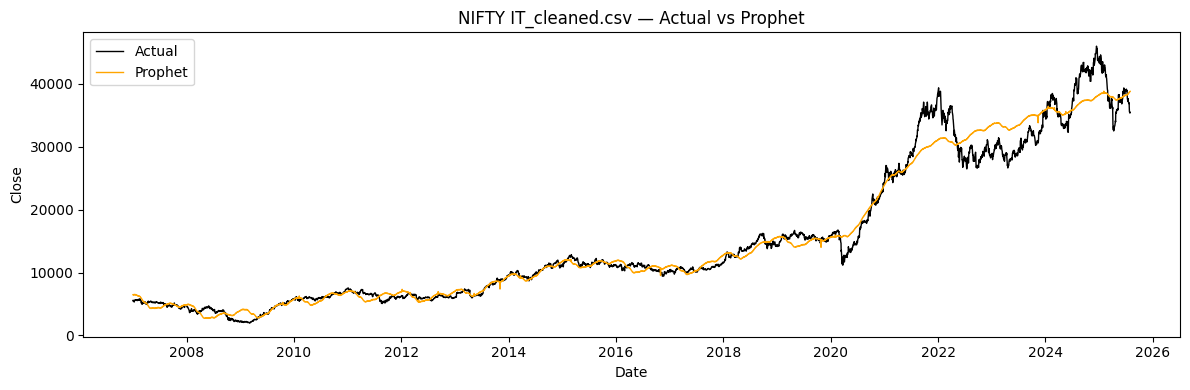

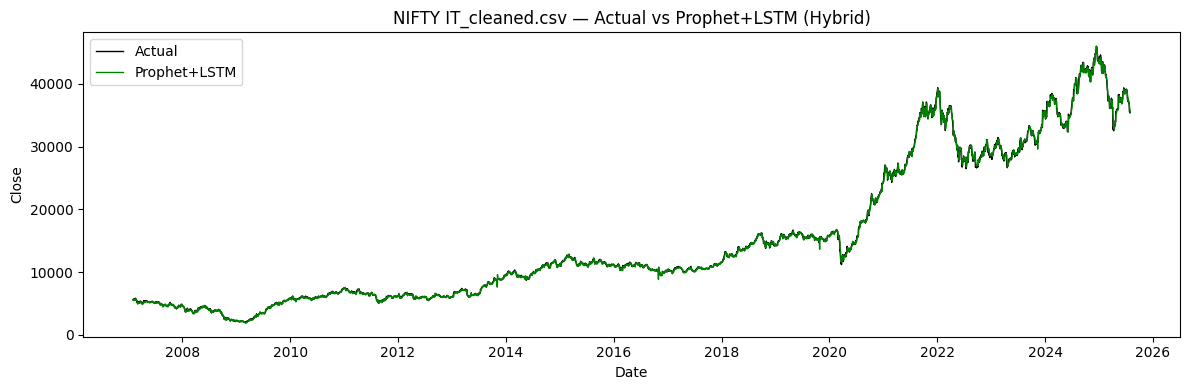


Processing NIFTY MEDIA_cleaned.csv ...


10:24:02 - cmdstanpy - INFO - Chain [1] start processing
10:24:04 - cmdstanpy - INFO - Chain [1] done processing


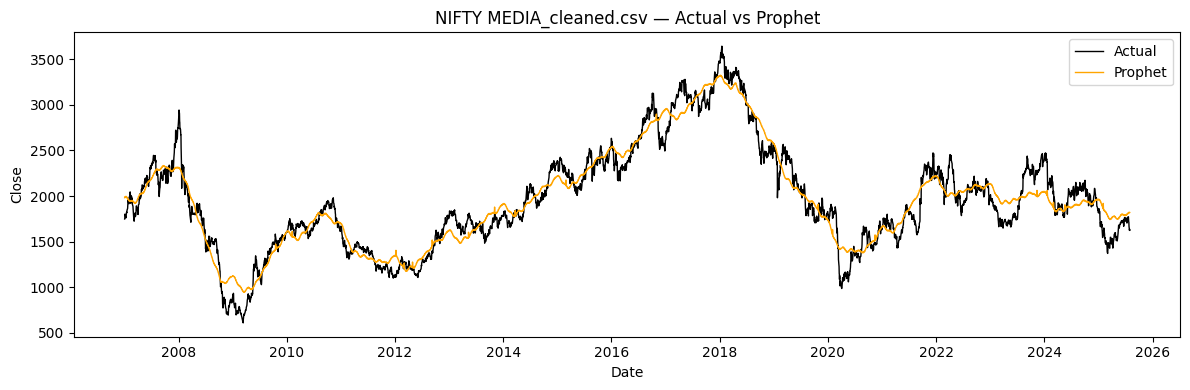

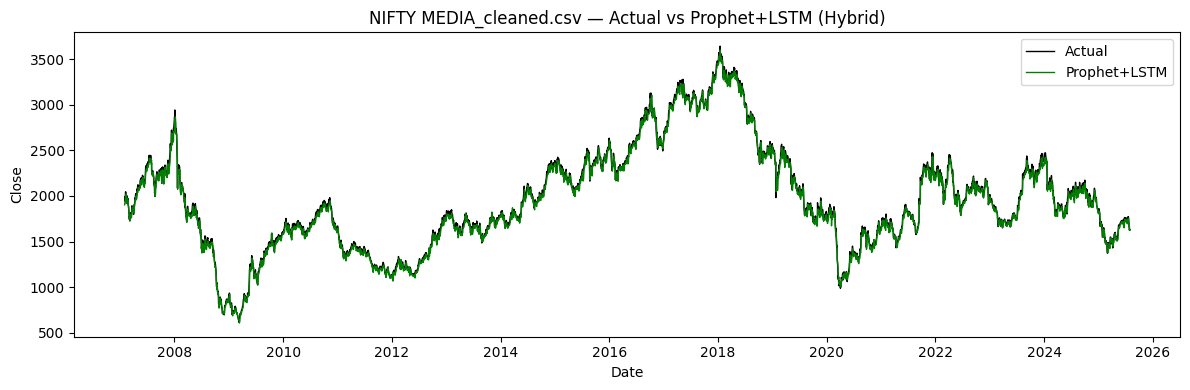


Processing NIFTY METAL_cleaned.csv ...


10:29:10 - cmdstanpy - INFO - Chain [1] start processing
10:29:12 - cmdstanpy - INFO - Chain [1] done processing


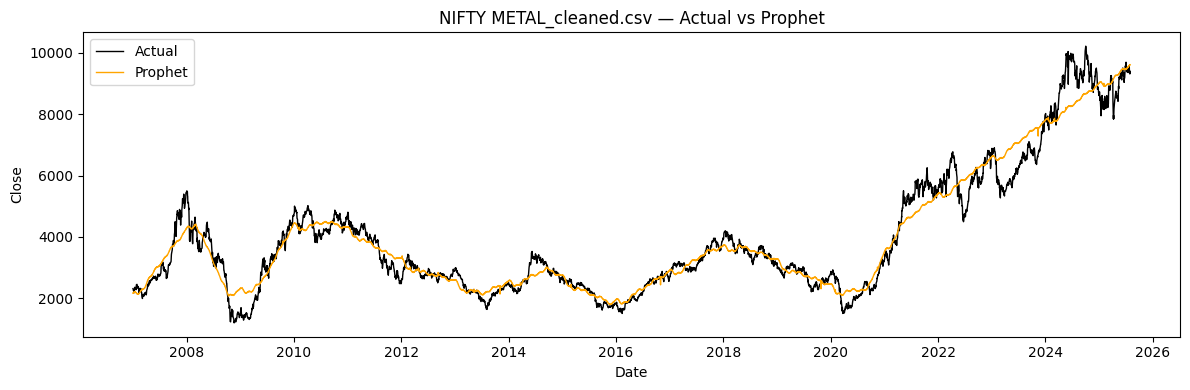

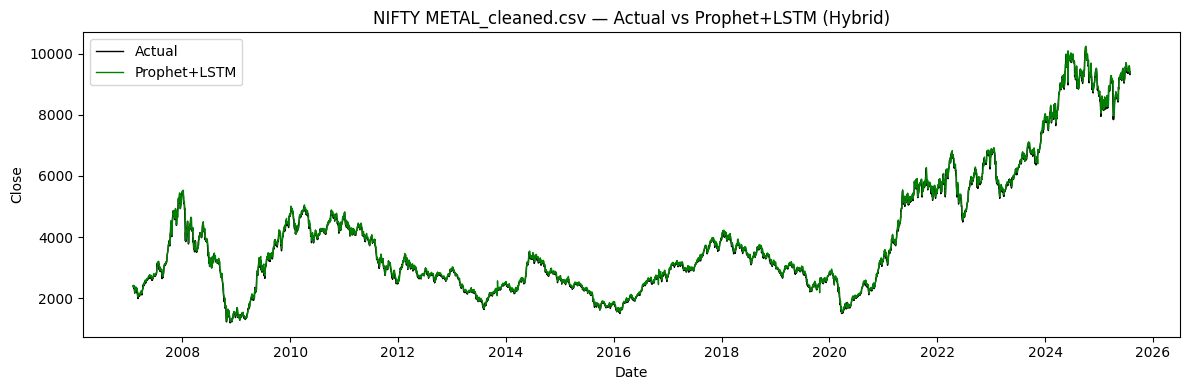


Processing NIFTY PHARMA_cleaned.csv ...


10:34:09 - cmdstanpy - INFO - Chain [1] start processing
10:34:11 - cmdstanpy - INFO - Chain [1] done processing


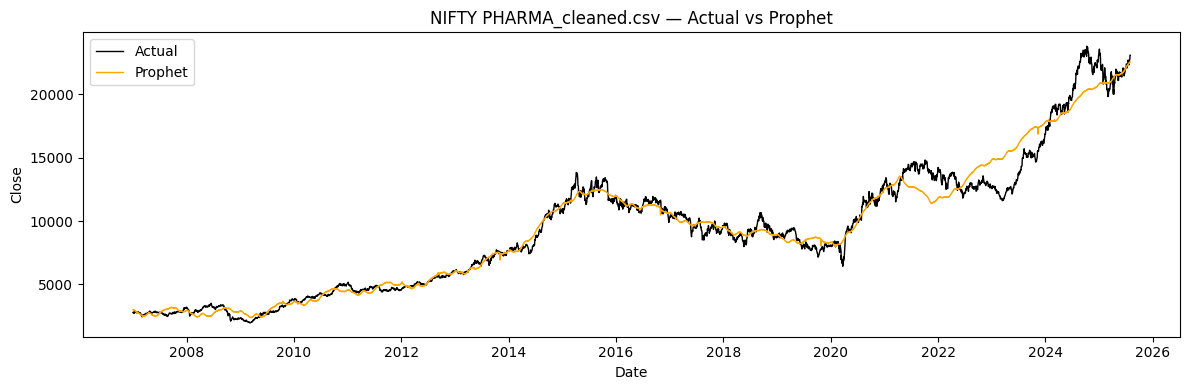

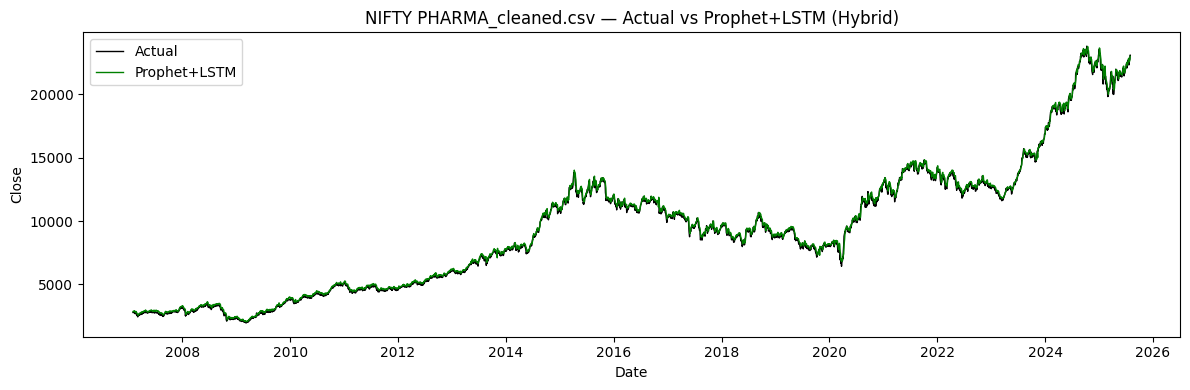


Processing NIFTY PRIVATE BANK_cleaned.csv ...


10:39:15 - cmdstanpy - INFO - Chain [1] start processing
10:39:17 - cmdstanpy - INFO - Chain [1] done processing


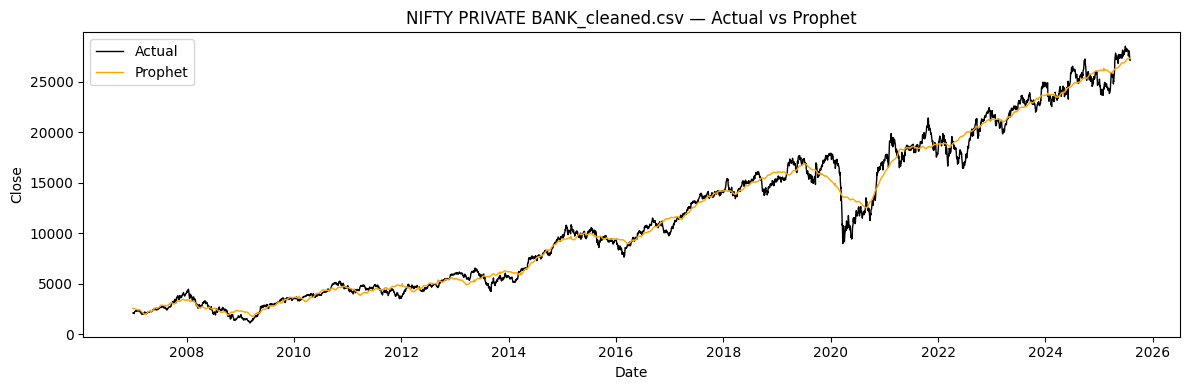

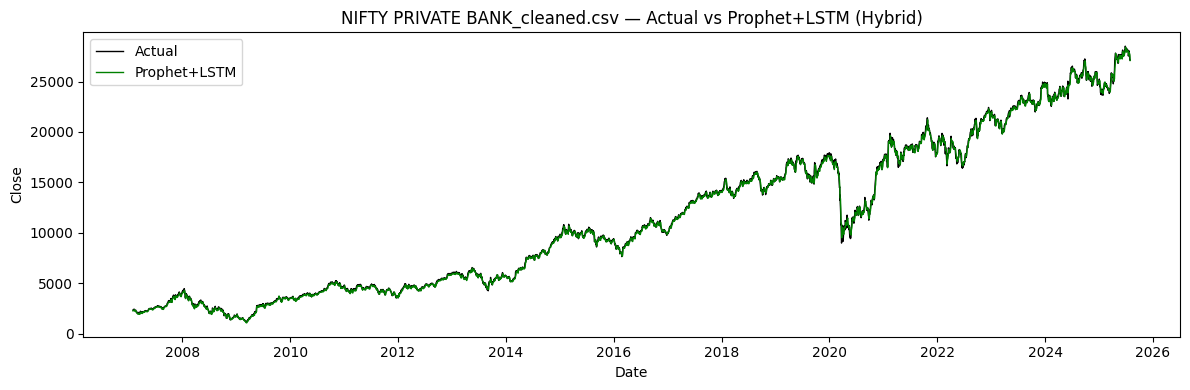


Processing NIFTY PSU BANK_cleaned.csv ...


10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing


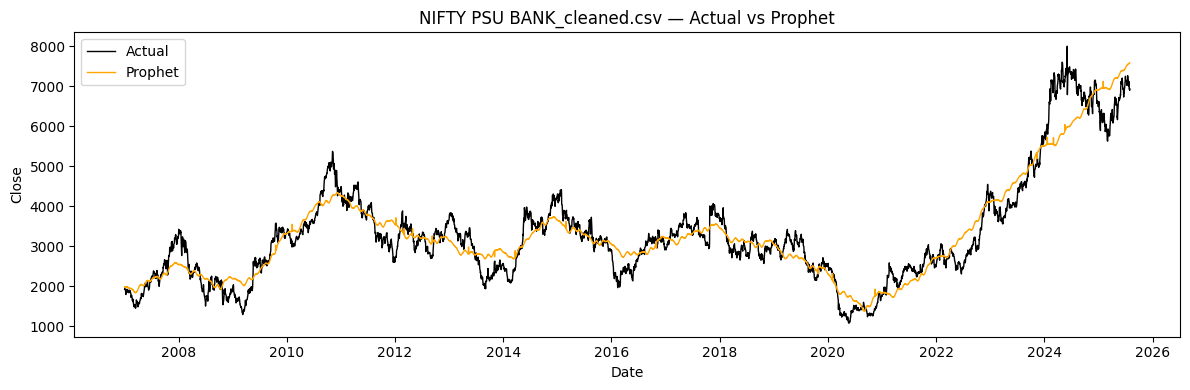

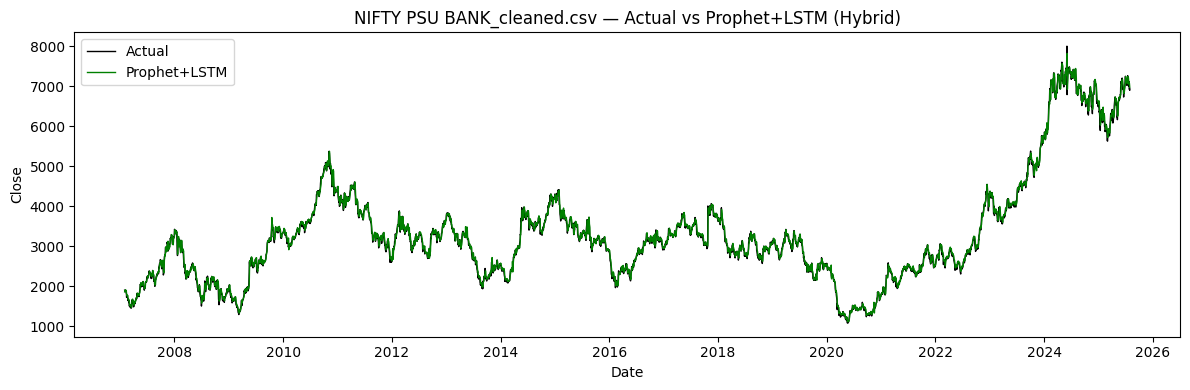


Processing NIFTY REALTY_cleaned.csv ...


10:49:30 - cmdstanpy - INFO - Chain [1] start processing
10:49:33 - cmdstanpy - INFO - Chain [1] done processing


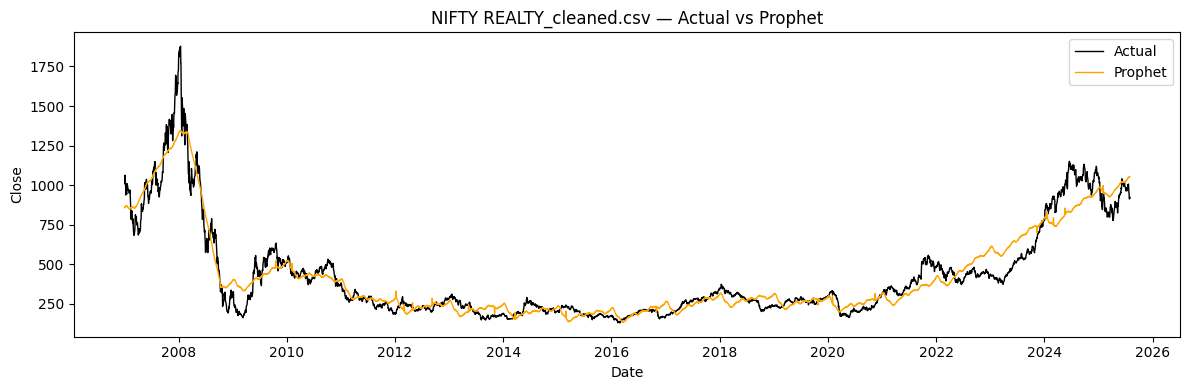

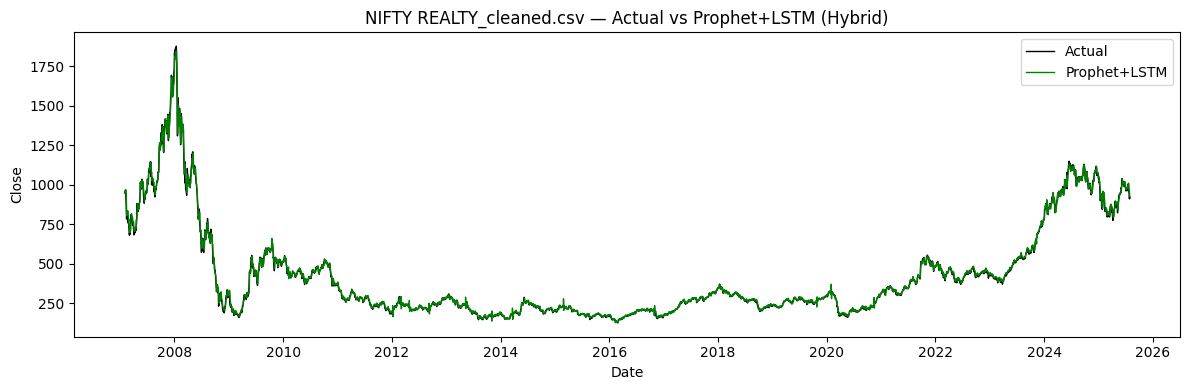


Files: 100%|██████████| 14/14 [1:12:59<00:00, 312.79s/it]


Metrics saved to prophet_and_hybrid_metrics.csv
Pivot metrics saved to prophet_and_hybrid_metrics_pivot.csv
Prophet plots directory: c:\Users\sohan\OneDrive\Desktop\python tut\hyb\plots\prophet
Hybrid plots directory: c:\Users\sohan\OneDrive\Desktop\python tut\hyb\plots\hybrid


In [4]:
# Jupyter-ready: Prophet baseline + Prophet+LSTM hybrid (fbprophet/prophet)
%matplotlib inline

# --- Install Prophet if missing (will run pip; may ask to restart kernel on some machines) ---
import sys, subprocess, pkg_resources
needed = {"prophet"}
installed = {pkg.key for pkg in pkg_resources.working_set}
if not any(p in installed for p in ("prophet", "fbprophet")):
    print("Installing prophet package (this may take a minute)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"], stdout=subprocess.DEVNULL)

# --- Imports ---
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# prophet import (support both names)
try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet

# ------------------ CONFIG ------------------
data_folder = r"C:\Users\sohan\Downloads\archive (1)"   # <-- update if needed
csv_files = sorted(glob.glob(os.path.join(data_folder, "*_cleaned.csv")))
# omit healthcare if present
csv_files = [f for f in csv_files if "HEALTHCARE" not in os.path.basename(f).upper()]

window_size = 20
lstm_epochs = 20
lstm_batch_size = 32
output_metrics_csv = "prophet_and_hybrid_metrics.csv"
output_pivot_csv = "prophet_and_hybrid_metrics_pivot.csv"

# Output folders for plots
plot_dir_prophet = "./plots/prophet"
plot_dir_hybrid = "./plots/hybrid"
os.makedirs(plot_dir_prophet, exist_ok=True)
os.makedirs(plot_dir_hybrid, exist_ok=True)

# Helper metric functions
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    eps = 1e-9
    return np.mean(np.abs((a - b) / (a + eps))) * 100

records = []

# Main loop
for file in tqdm(csv_files, desc="Files"):
    name = os.path.basename(file)
    print(f"\nProcessing {name} ...")
    df = pd.read_csv(file)
    # ensure Date and sorting
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df = df[['Date','Close']].copy()

    # Prepare data for Prophet: ds, y
    prophet_df = df.rename(columns={'Date':'ds', 'Close':'y'})[['ds','y']].copy()
    # Fit Prophet (in-sample)
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
    m.fit(prophet_df)

    # In-sample predict
    forecast = m.predict(prophet_df)
    df['Prophet'] = forecast['yhat'].values

    # Prophet baseline metrics (in-sample)
    prophet_true = df['Close'].values
    prophet_pred = df['Prophet'].values
    prophet_mae = mean_absolute_error(prophet_true, prophet_pred)
    prophet_rmse = rmse(prophet_true, prophet_pred)
    prophet_mape = mape(prophet_true, prophet_pred)
    prophet_r2 = r2_score(prophet_true, prophet_pred)

    # Residuals for LSTM
    df['Residuals'] = df['Close'] - df['Prophet']
    residuals = df['Residuals'].values.reshape(-1,1)

    # If too short for LSTM windows, save only prophet metrics
    if len(residuals) <= window_size + 1:
        print(f"  Skipping LSTM for {name}: series too short (len={len(residuals)}). Saving Prophet metrics only.")
        records.append({
            'file': name,
            'model': 'Prophet',
            'MAE': prophet_mae,
            'RMSE': prophet_rmse,
            'MAPE (%)': prophet_mape,
            'R2': prophet_r2
        })
        # Plot Prophet only
        plt.figure(figsize=(12,4))
        plt.plot(df['Date'], df['Close'], label='Actual', color='black', linewidth=1)
        plt.plot(df['Date'], df['Prophet'], label='Prophet', color='orange', linewidth=1)
        plt.title(f"{name} — Actual vs Prophet")
        plt.xlabel('Date'); plt.ylabel('Close'); plt.legend()
        plt.tight_layout()
        f1 = os.path.join(plot_dir_prophet, f"{name.replace('.csv','')}_actual_vs_prophet.png")
        plt.savefig(f1, dpi=200)
        plt.show()
        plt.close()
        continue

    # scale residuals
    scaler = MinMaxScaler()
    residuals_scaled = scaler.fit_transform(residuals)

    # create supervised windows
    X, y = [], []
    for i in range(len(residuals_scaled) - window_size):
        X.append(residuals_scaled[i:i+window_size])
        y.append(residuals_scaled[i+window_size])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # build and train LSTM
    lstm_model = Sequential([
        Input(shape=(window_size,1)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    lstm_model.fit(X, y, epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=0, callbacks=[early_stop])

    # Rolling forecast of residuals (feed actual scaled residual to window each step)
    lstm_pred_scaled = []
    seed_window = residuals_scaled[:window_size].reshape(1, window_size, 1)
    window = seed_window.copy()
    for i in range(window_size, len(residuals_scaled)):
        pred_scaled = lstm_model.predict(window, verbose=0)
        lstm_pred_scaled.append(pred_scaled[0][0])
        next_val_scaled = residuals_scaled[i].reshape(1,1,1)
        window = np.concatenate((window[:,1:,:], next_val_scaled), axis=1)

    lstm_pred_scaled = [np.nan]*window_size + lstm_pred_scaled
    lstm_pred = scaler.inverse_transform(np.array(lstm_pred_scaled).reshape(-1,1)).flatten()

    df['Hybrid'] = df['Prophet'] + lstm_pred
    df_metrics = df.dropna(subset=['Hybrid']).copy()

    # Hybrid metrics
    hybrid_true = df_metrics['Close'].values
    hybrid_pred = df_metrics['Hybrid'].values
    hybrid_mae = mean_absolute_error(hybrid_true, hybrid_pred)
    hybrid_rmse = rmse(hybrid_true, hybrid_pred)
    hybrid_mape = mape(hybrid_true, hybrid_pred)
    hybrid_r2 = r2_score(hybrid_true, hybrid_pred)

    # Append metrics for both models
    records.append({
        'file': name,
        'model': 'Prophet',
        'MAE': prophet_mae,
        'RMSE': prophet_rmse,
        'MAPE (%)': prophet_mape,
        'R2': prophet_r2
    })
    records.append({
        'file': name,
        'model': 'Prophet+LSTM',
        'MAE': hybrid_mae,
        'RMSE': hybrid_rmse,
        'MAPE (%)': hybrid_mape,
        'R2': hybrid_r2
    })

    # Plot 1: Actual vs Prophet
    plt.figure(figsize=(12,4))
    plt.plot(df['Date'], df['Close'], label='Actual', color='black', linewidth=1)
    plt.plot(df['Date'], df['Prophet'], label='Prophet', color='orange', linewidth=1)
    plt.title(f"{name} — Actual vs Prophet")
    plt.xlabel('Date'); plt.ylabel('Close'); plt.legend()
    plt.tight_layout()
    f1 = os.path.join(plot_dir_prophet, f"{name.replace('.csv','')}_actual_vs_prophet.png")
    plt.savefig(f1, dpi=200)
    plt.show()
    plt.close()

    # Plot 2: Actual vs Hybrid (only where Hybrid exists)
    plt.figure(figsize=(12,4))
    plt.plot(df_metrics['Date'], df_metrics['Close'], label='Actual', color='black', linewidth=1)
    plt.plot(df_metrics['Date'], df_metrics['Hybrid'], label='Prophet+LSTM', color='green', linewidth=1)
    plt.title(f"{name} — Actual vs Prophet+LSTM (Hybrid)")
    plt.xlabel('Date'); plt.ylabel('Close'); plt.legend()
    plt.tight_layout()
    f2 = os.path.join(plot_dir_hybrid, f"{name.replace('.csv','')}_actual_vs_hybrid.png")
    plt.savefig(f2, dpi=200)
    plt.show()
    plt.close()

# Save metrics
metrics_df = pd.DataFrame(records)
metrics_df = metrics_df[['file','model','MAE','RMSE','MAPE (%)','R2']]
metrics_df.to_csv(output_metrics_csv, index=False)
print(f"\nMetrics saved to {output_metrics_csv}")

# Create pivoted table (one row per file, columns for Prophet & Hybrid metrics)
pivot = metrics_df.pivot(index='file', columns='model')
# flatten multiindex columns
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()
pivot.to_csv(output_pivot_csv, index=False)
print(f"Pivot metrics saved to {output_pivot_csv}")

print(f"Prophet plots directory: {os.path.abspath(plot_dir_prophet)}")
print(f"Hybrid plots directory: {os.path.abspath(plot_dir_hybrid)}")

In [2]:
!pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension


  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   -------------------------------- ------- 112.6/139.8 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 139.8/139.8 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/616.2 kB ? eta -:--:--
   ------------------- -------------------- 307.2/616.2 kB 9.6 MB/s eta 0:00:01
   ---------------------------------------  614.4/616.2 kB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 616.2/616.2 kB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.6 kB ? eta -:--:--
   -------------------------- ------------- 143.4/216.6 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------  215.0/216.6 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 216.6/216.6 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
   ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\sohan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --j